In [1]:
import vk  
import vk_api
import requests
import json
import time 
import datetime
import csv
import pandas as pd

ModuleNotFoundError: No module named 'vk'

### Функция сбора пользователей по следующим критериям
* country_id  Код страны
* id_city     Код города
* univercity_id  Код универа
* uni_year_id Год выпуска
* school_year

# Парсинг по году выпуска из школы

In [65]:
def search_users(access_token, year):  # Функция формирования базы участников сообщества в виде списка
    
    ''' В качестве аргумента функции будет подаваться:
    массив года выпуска из школы и id университета'''
    univercity_id =853                 # переменную заношу в локальную
    user_school_list = []
    for school_year in year:
        first = vk_api.users.search(access_token=access_token, 
                                university= univercity_id, 
                                school_year = school_year, 
                                v=5.131, 
                                count=1000)
        user_school_list.extend(first['items'])
        
        user_list = []
        for i in range(len(user_school_list)):
            user_list.append(user_school_list[i])                 # Получили JSON
    df_school = pd.DataFrame(user_list)                           # Создаем датафрейм из JSON
    
    df_school = df_school.query('is_closed == False')               # Фильтруем по открытости страниц
    
    df_no_duplicates = df_school.drop_duplicates('id', keep='last') # убираем дубликаты из ДФ и записываем в новый ДФ
    
    df_no_duplicates.reset_index(inplace=True)                      # сбрасываем индексацию для беребора в цикле
    
    series_year = df_no_duplicates['id']                           # получаем серию выпускников с 18 года по 21 год

    return series_year


### Получаем серию ID с годом выпуска из школы 2018, 2019, 2020,2021

In [66]:

if __name__ == "__main__": 
    vk_session = vk_api.VkApi('user@email.com', 'password')                              # сюда вписываем почту и пароль
    vk_session.auth()
    vk_api = vk_session.get_api() 
    access_token = 'token_id'    # сюда записываем токен id
    year = [2018, 2019, 2020,2021]
    univercity_id = 853
    ret_school = search_users(access_token, year)

In [68]:
ret_school

0      180503694
1      325220518
2      450474852
3      218703467
4      180622887
         ...    
893    274955398
894    264554481
895    276546953
896    242894531
897    247429650
Name: id, Length: 898, dtype: int64

## Функция получения списка групп по activity. Если сообщество - выодится его тематика "activity" если группа выводится открытая или закрытая.

 Для каждого участника будет выведено 10 групп. Если количество групп, состоящих меньше или пользователь запретил просмотр его групп просто пропускаем. Это делается путем обработки исключений `try / except`

In [71]:
def groups_id(access_token, series): 
    all_groups = []
    for user_id in series:
        time.sleep(2)
        groups = vk_api.groups.get(access_token=access_token, 
                                   user_id= user_id, 
                                   extended =1, 
                                   count=10, 
                                   fields = 'activity', 
                                   v=5.131)        
        all_groups.extend(groups['items'])
        alist= []
        for i in range(len(series)):                # Пробегаем циклом собираем группы по 10 штук
            for j in range(10):
                alist.append(i)
    try:
        for z,k in enumerate(alist):
            all_groups[z]['id'] = series[k]         # Каждой группе присваиваем id участника и его activity
    except:
        pass
    return all_groups

In [72]:
if __name__ == "__main__": 
    vk_session = vk_api.VkApi('user@email.com', 'password')
    vk_session.auth()
    vk_api = vk_session.get_api() 
    access_token = 'token_id'
    group_2021 = groups_id(access_token, ret_school)

Создаем датафрейм из **group_2021**

In [73]:
df_group_school = pd.DataFrame(group_2021)

### Производим транспонирование датафрейма. По id в качестве колонок будут, колонки с activity от одного до 10. Если пользователь состоит в количестве групп меньше 10, то значения будут заполняться `nAn`

In [92]:
df_school_group = df_group_school.assign(idx=(df_group_school.groupby("id").cumcount()+1)      \
                                 .astype(str).str.replace("^(.)", "activity_\\1", regex=True)) \
                                 .pivot(index="id", columns="idx", values="activity")
df_school_group.reset_index()

idx,id,activity_1,activity_10,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9
0,2080926,Открытая группа,Юмор,Обмен музыкой,Кино,Уход за собой,Юмор,Юмор,Юмор,Открытая группа,Юмор
1,3703841,Музыкант,Открытая группа,Литература,Знакомства,Знакомства,Публичная страница,Молодёжное движение,Знакомства,Открытая группа,Блогер
2,12678075,Юмор,Образование,Юмор,Юмор,Юмор,Юмор,Юмор,Юмор,Юмор,Программирование
3,13449601,Молодёжное движение,Молодёжное движение,Кино,Юмор,Юмор,Общественная организация,Юмор,Юмор,Фотография,"Шоу, передача"
4,15309993,"Rap, Hip-Hop",Объявления,Фитнес,Юмор,"Шоу, передача",Юмор,Юмор,Юмор,Юмор,"Туризм, путешествия"
...,...,...,...,...,...,...,...,...,...,...,...
788,633960785,Городское сообщество,Кино,Юмор,Молодёжное движение,Знакомства,Университет,Группа сокурсников,Молодёжное движение,Кино,Университет
789,635139776,Финансы,Юмор,Молодёжное движение,Доставка еды,Городское сообщество,Юмор,Городское сообщество,"Кулинария, рецепты",Игры,Открытая группа
790,639418663,Юмор,Молодёжное движение,Объявления,Литература,Автомобили,Городское сообщество,Молодёжное движение,Фотография,Молодёжное движение,Молодёжное движение
791,644982519,Юмор,Литература,Юмор,Юмор,Юмор,"Астрология, эзотерика",Юмор,Юмор,Юмор,Юмор


# Получаем информацию о ЮЗЕРАХ 

* faculty_name (string)— название факультета;
* sex 1 - женский 2 - мужской 3 - не указан

In [84]:
def users_info(access_token, series):  # Функция формирования базы участников сообщества в виде списка
    all_users = []
    for user_id in series:
        time.sleep(5)
        users_get = vk_api.users.get(access_token=access_token, 
                                   user_id= user_id,  
                                   fields = ['education', 'sex'],
                                   v=5.89)
        all_users.append(users_get)
        
        users_list = []
    for i in range(len(all_users)):
        users_list.append(all_users[i][0])
    df_users_info = pd.DataFrame(users_list)                # создаем датафрейм
    return df_users_info[['id', 'sex', 'faculty_name', 'graduation' ]]

In [85]:
if __name__ == "__main__": 
    vk_session = vk_api.VkApi('user@email.com', 'password')
    vk_session.auth()
    vk_api = vk_session.get_api() 
    access_token = 'token_id'
    users_2021 = users_info(access_token, ret_school)

In [86]:
users_2021

,id,sex,faculty_name,graduation
0,180503694,2,Инженерная школа новых производственных технол...,2014.0
1,325220518,2,NaN,NaN
2,450474852,2,NaN,NaN
3,218703467,2,NaN,NaN
4,180622887,2,NaN,NaN
...,...,...,...,...
893,274955398,2,,0.0
894,264554481,1,,0.0
895,276546953,2,Инженерная школа новых производственных технол...,2020.0
896,242894531,2,Инженерная школа новых производственных технол...,2020.0


### Конкатенируем Датафреймы `df_group_school` и ` users_2021`

In [94]:
df_merge = pd.merge(users_2021, df_school_group, how='left', on='id')
df_merge

,id,sex,faculty_name,graduation,activity_1,activity_10,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,activity_8,activity_9
0,180503694,2,Инженерная школа новых производственных технол...,2014.0,Открытая группа,Городское сообщество,Интернет-СМИ,Открытая группа,Открытая группа,Закрытая группа,Рыбалка,Наука,Юмор,Юмор
1,325220518,2,NaN,NaN,Юмор,Юмор,Юмор,Юмор,Юмор,Юмор,Образование,Спортивная организация,Вымышленный персонаж,Наука
2,450474852,2,NaN,NaN,Юмор,Группа сокурсников,Торгово-развлекательный центр,Юмор,Кино,Юмор,Молодёжное движение,Автомобили,Юмор,Театр
3,218703467,2,NaN,NaN,Домашние и дикие животные,Юмор,Друзья,Юмор,Юмор,Автомойка,Компьютерная техника,Наука,Молодёжное движение,Юмор
4,180622887,2,NaN,NaN,Блог,"Техника, электроника",Юмор,Юмор,Знакомства,Юмор,Образование,Юмор,Юмор,Кинотеатр
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,274955398,2,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
894,264554481,1,,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,276546953,2,Инженерная школа новых производственных технол...,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,242894531,2,Инженерная школа новых производственных технол...,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Чтобы потом было легче работать сохраняем датасет в csv

In [98]:
df_merge.to_csv('school_18_21.csv', encoding ='CP1251')

# Создаем матрицу смежности 

#### Создадим матрицу, index = id, column = id

In [136]:
index = ret_school                   # Индексный столбец серия ID
columns =ret_school
dfm = pd.DataFrame(index=index, columns=columns)  # Колонки серия ID
dfm = dfm.fillna(0)                               # заполняем нулями
dfm.reset_index()
dfm

id,180503694,325220518,450474852,218703467,180622887,87316133,319676972,222296178,235994394,231819276,...,297766738,241013137,248486065,323134114,278230724,274955398,264554481,276546953,242894531,247429650
id,,,,,,,,,,,,,,,,,,,,,
180503694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325220518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
450474852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218703467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180622887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274955398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264554481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276546953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Создаем функцию. 

### Функция находит друзей из столбца проверяет есть ли вхождение ID из столбца INDEX в списке друзей человека, если есть устанавливает на пересечении 1, если нет устанавливает 1.

In [138]:
def friends(access_token, series):
    for i, user_id in enumerate(series):
        friends_get = vk_api.friends.get(access_token=access_token, 
                                   user_id= user_id,
                                   v=5.89)
        for k in range(len(series)):
            if series[k] in friends_get['items']:
                dfm.iloc[k,i] = 1
            else:
                dfm.iloc[k,i] = 0    
    return dfm
    

In [139]:
if __name__ == "__main__": 
    vk_session = vk_api.VkApi('user@email.com', 'password')
    vk_session.auth()
    vk_api = vk_session.get_api() 
    access_token = 'token_id'
    friends_series = ret_school
    friends_test = friends(access_token, friends_series)

In [140]:
friends_test

id,180503694,325220518,450474852,218703467,180622887,87316133,319676972,222296178,235994394,231819276,...,297766738,241013137,248486065,323134114,278230724,274955398,264554481,276546953,242894531,247429650
id,,,,,,,,,,,,,,,,,,,,,
180503694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325220518,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
450474852,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218703467,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180622887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274955398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264554481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276546953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
friends_test.to_csv('matrix_adj.csv', encoding ='CP1251')
    

In [1]:
import pandas as pd

In [2]:
df_m = pd.read_csv('matrix_adj.csv', sep = ';')

In [3]:
df_m

,id,180503694,325220518,450474852,218703467,180622887,87316133,319676972,222296178,235994394,...,159272419,168797292,384302368,327240994,281733383,208031023,261219892,190384898,260055166,269364355
0,180503694,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,325220518,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,450474852,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,218703467,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,180622887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,208031023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
789,261219892,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,190384898,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
791,260055166,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Создаем словарь для замены id чтобы не потерять
id_key = {180503694 : 1,
325220518 : 2,
450474852 : 3,
218703467 : 4,
180622887 : 5,
87316133 : 6,
319676972 : 7,
222296178 : 8,
235994394 : 9,
231819276 : 10,
133034335 : 11,
198821161 : 12,
362767422 : 13,
89355074 : 14,
295507272 : 15,
182468104 : 16,
229685901 : 17,
183605173 : 18,
192614091 : 19,
304437925 : 20,
474655544 : 21,
345556694 : 22,
176236396 : 23,
211605776 : 24,
183235731 : 25,
186414826 : 26,
184352627 : 27,
215638080 : 28,
284372657 : 29,
362280577 : 30,
428223920 : 31,
348942271 : 32,
463074427 : 33,
188928885 : 34,
211337152 : 35,
223076649 : 36,
197511807 : 37,
203197142 : 38,
143972089 : 39,
155015513 : 40,
93065981 : 41,
116684896 : 42,
138951934 : 43,
229867836 : 44,
217214565 : 45,
174235142 : 46,
237681299 : 47,
199679877 : 48,
198303384 : 49,
175750670 : 50,
202164704 : 51,
238511589 : 52,
183702900 : 53,
240068033 : 54,
145452565 : 55,
127722145 : 56,
143094618 : 57,
143066641 : 58,
34248872 : 59,
160334970 : 60,
149461299 : 61,
169721890 : 62,
143272572 : 63,
156222885 : 64,
153459191 : 65,
145751440 : 66,
88689317 : 67,
81079210 : 68,
137948617 : 69,
103837657 : 70,
172622048 : 71,
156931931 : 72,
129027347 : 73,
266069985 : 74,
191469893 : 75,
191308152 : 76,
367443839 : 77,
363188996 : 78,
406231242 : 79,
228454311 : 80,
327937695 : 81,
194959051 : 82,
150521988 : 83,
141050255 : 84,
162522461 : 85,
152962090 : 86,
114633441 : 87,
138091773 : 88,
171734397 : 89,
153058925 : 90,
160027576 : 91,
161292658 : 92,
290094122 : 93,
205788460 : 94,
263609616 : 95,
177531270 : 96,
249400014 : 97,
154104759 : 98,
127364499 : 99,
148326403 : 100,
200477354 : 101,
147523346 : 102,
144958489 : 103,
108376550 : 104,
73842399 : 105,
318949908 : 106,
210079563 : 107,
259068034 : 108,
210684208 : 109,
194541509 : 110,
253332682 : 111,
249133528 : 112,
108598402 : 113,
139111611 : 114,
158334561 : 115,
160341692 : 116,
145789643 : 117,
135181930 : 118,
150524897 : 119,
166455774 : 120,
136907429 : 121,
73511136 : 122,
157305825 : 123,
137725369 : 124,
104690751 : 125,
496003803 : 126,
200724266 : 127,
204209979 : 128,
88726312 : 129,
216377284 : 130,
192464381 : 131,
224481969 : 132,
114908112 : 133,
211664844 : 134,
185756553 : 135,
154302899 : 136,
215095002 : 137,
145328994 : 138,
160451734 : 139,
136202858 : 140,
136523605 : 141,
88864938 : 142,
133455127 : 143,
150330009 : 144,
253984691 : 145,
86895575 : 146,
168227624 : 147,
143491615 : 148,
265481293 : 149,
205395831 : 150,
236566263 : 151,
192703669 : 152,
349844005 : 153,
138886531 : 154,
143309601 : 155,
175977415 : 156,
95668205 : 157,
123135648 : 158,
112445019 : 159,
230127319 : 160,
263587678 : 161,
168340933 : 162,
250803026 : 163,
223709630 : 164,
244315918 : 165,
183440354 : 166,
169167680 : 167,
147841162 : 168,
309282279 : 169,
149068095 : 170,
180525885 : 171,
41905182 : 172,
304583948 : 173,
87525730 : 174,
150706805 : 175,
174569065 : 176,
156351113 : 177,
202909982 : 178,
343138900 : 179,
238389006 : 180,
269429176 : 181,
201447460 : 182,
278894023 : 183,
15309993 : 184,
499882775 : 185,
134640106 : 186,
366741866 : 187,
240909726 : 188,
99804852 : 189,
28192517 : 190,
478940365 : 191,
417322594 : 192,
139415605 : 193,
499352715 : 194,
488058027 : 195,
478378814 : 196,
143369017 : 197,
255862657 : 198,
162898680 : 199,
140332833 : 200,
339607995 : 201,
170553562 : 202,
497210934 : 203,
234699041 : 204,
568014499 : 205,
139455449 : 206,
186688036 : 207,
516681349 : 208,
254554407 : 209,
531399096 : 210,
190498647 : 211,
229179251 : 212,
282244759 : 213,
254082509 : 214,
163652586 : 215,
210127461 : 216,
253406989 : 217,
393493013 : 218,
366525018 : 219,
222558528 : 220,
198928683 : 221,
429050473 : 222,
288586755 : 223,
208880871 : 224,
232555188 : 225,
138499122 : 226,
163705649 : 227,
164666914 : 228,
180434460 : 229,
167220268 : 230,
145159949 : 231,
149548525 : 232,
162534410 : 233,
136549149 : 234,
91008378 : 235,
164731018 : 236,
132380525 : 237,
97834266 : 238,
132830589 : 239,
179971643 : 240,
27418522 : 241,
635139776 : 242,
85410207 : 243,
13449601 : 244,
232812005 : 245,
523574121 : 246,
197523610 : 247,
242624395 : 248,
255927508 : 249,
208712091 : 250,
241903050 : 251,
193146883 : 252,
639418663 : 253,
633960785 : 254,
209765671 : 255,
272208614 : 256,
205570601 : 257,
192949492 : 258,
319441778 : 259,
309294451 : 260,
169541127 : 261,
193408399 : 262,
157347465 : 263,
222294971 : 264,
208465124 : 265,
173832283 : 266,
211689961 : 267,
12678075 : 268,
134220383 : 269,
278334707 : 270,
498956032 : 271,
277274997 : 272,
208774785 : 273,
445742358 : 274,
308258245 : 275,
559129876 : 276,
169066675 : 277,
182871868 : 278,
194524334 : 279,
230448839 : 280,
182226458 : 281,
196611763 : 282,
200098799 : 283,
195313334 : 284,
229812210 : 285,
426643102 : 286,
474399209 : 287,
279020553 : 288,
287728435 : 289,
482430501 : 290,
389070783 : 291,
301160721 : 292,
290254033 : 293,
230061862 : 294,
191322413 : 295,
189660497 : 296,
202227284 : 297,
220654915 : 298,
150534842 : 299,
158755655 : 300,
138279327 : 301,
490132026 : 302,
373295587 : 303,
442655970 : 304,
235707277 : 305,
267705603 : 306,
248830279 : 307,
186805891 : 308,
245342491 : 309,
215160256 : 310,
244946077 : 311,
175476047 : 312,
250911242 : 313,
225257141 : 314,
253947043 : 315,
180635730 : 316,
276765405 : 317,
194305702 : 318,
254444905 : 319,
182705887 : 320,
188096914 : 321,
268057576 : 322,
150287068 : 323,
133261362 : 324,
144763471 : 325,
133976284 : 326,
54701157 : 327,
31141546 : 328,
143475130 : 329,
159875595 : 330,
197555753 : 331,
223929908 : 332,
239468342 : 333,
254738647 : 334,
219375362 : 335,
175699843 : 336,
245215134 : 337,
241809555 : 338,
269729558 : 339,
289434626 : 340,
308138457 : 341,
364740357 : 342,
347833312 : 343,
248690311 : 344,
338159537 : 345,
82669172 : 346,
217139958 : 347,
191535664 : 348,
138766932 : 349,
139567091 : 350,
150889177 : 351,
142225279 : 352,
171325129 : 353,
164293991 : 354,
145422407 : 355,
170625377 : 356,
144862573 : 357,
316341502 : 358,
311234838 : 359,
173353243 : 360,
206951475 : 361,
213781352 : 362,
216878310 : 363,
196166972 : 364,
254569331 : 365,
269837616 : 366,
220895567 : 367,
188950508 : 368,
2080926 : 369,
138065102 : 370,
166515045 : 371,
52288016 : 372,
88639229 : 373,
145828188 : 374,
140037379 : 375,
139640798 : 376,
248497026 : 377,
178294360 : 378,
189092215 : 379,
216873950 : 380,
259311538 : 381,
276639984 : 382,
224899564 : 383,
173686091 : 384,
145074105 : 385,
171668427 : 386,
431663194 : 387,
341622644 : 388,
182025591 : 389,
263917645 : 390,
158851911 : 391,
119531495 : 392,
185811514 : 393,
355995936 : 394,
236893554 : 395,
196850795 : 396,
142988694 : 397,
163814770 : 398,
228716133 : 399,
570884756 : 400,
501207697 : 401,
142386511 : 402,
147056083 : 403,
147151818 : 404,
283312849 : 405,
206080836 : 406,
170932244 : 407,
220854966 : 408,
161168783 : 409,
178383096 : 410,
382124413 : 411,
180461641 : 412,
252689440 : 413,
183605649 : 414,
139415999 : 415,
345016850 : 416,
188360302 : 417,
373891657 : 418,
558983758 : 419,
547366240 : 420,
287041054 : 421,
232907013 : 422,
134214890 : 423,
287871104 : 424,
98704870 : 425,
303063459 : 426,
210498441 : 427,
346816557 : 428,
244059049 : 429,
177189659 : 430,
175682870 : 431,
182719741 : 432,
124389002 : 433,
151273597 : 434,
340235907 : 435,
149031157 : 436,
161865937 : 437,
203177556 : 438,
292112039 : 439,
193265090 : 440,
260060979 : 441,
181729439 : 442,
167176638 : 443,
143106227 : 444,
135934930 : 445,
135047879 : 446,
457981613 : 447,
392343638 : 448,
139391296 : 449,
193426329 : 450,
223054370 : 451,
474065796 : 452,
301511253 : 453,
107187717 : 454,
316265914 : 455,
512755204 : 456,
159010256 : 457,
266134499 : 458,
122006640 : 459,
211466591 : 460,
666097252 : 461,
612958590 : 462,
300651660 : 463,
275029675 : 464,
325003887 : 465,
195157893 : 466,
184599329 : 467,
505308855 : 468,
225384504 : 469,
561850121 : 470,
161400368 : 471,
180242409 : 472,
216062731 : 473,
251455931 : 474,
240241141 : 475,
374059721 : 476,
227280690 : 477,
306503672 : 478,
281336195 : 479,
224672605 : 480,
355403039 : 481,
217232064 : 482,
209270071 : 483,
292223520 : 484,
263025419 : 485,
308693621 : 486,
195087983 : 487,
192641887 : 488,
186507544 : 489,
585266335 : 490,
216515602 : 491,
162750234 : 492,
174913739 : 493,
180502556 : 494,
462173259 : 495,
147481415 : 496,
144527771 : 497,
146529423 : 498,
137520606 : 499,
126137632 : 500,
134575694 : 501,
16697377 : 502,
208025342 : 503,
17835405 : 504,
24125338 : 505,
216928077 : 506,
91667790 : 507,
274652643 : 508,
255432336 : 509,
265344611 : 510,
209718019 : 511,
275991576 : 512,
169699091 : 513,
234624514 : 514,
304776597 : 515,
190932065 : 516,
236060837 : 517,
191058679 : 518,
193743818 : 519,
165828487 : 520,
170721557 : 521,
289279869 : 522,
184531305 : 523,
353990381 : 524,
300388871 : 525,
277955227 : 526,
186176901 : 527,
246463155 : 528,
547768068 : 529,
244295749 : 530,
325633778 : 531,
286293179 : 532,
246358771 : 533,
120897076 : 534,
234895268 : 535,
230060217 : 536,
218113066 : 537,
255788250 : 538,
194641909 : 539,
228757469 : 540,
309298377 : 541,
324666355 : 542,
280639504 : 543,
239001144 : 544,
209426610 : 545,
218963356 : 546,
414619788 : 547,
432466009 : 548,
291391182 : 549,
397012947 : 550,
300247617 : 551,
325481676 : 552,
424360039 : 553,
221777610 : 554,
233548955 : 555,
192350069 : 556,
223092125 : 557,
286801232 : 558,
280768364 : 559,
235744189 : 560,
218537485 : 561,
240831536 : 562,
244039499 : 563,
213143584 : 564,
227959331 : 565,
236743399 : 566,
221122451 : 567,
269954125 : 568,
163708486 : 569,
27265972 : 570,
120687854 : 571,
115182829 : 572,
185772441 : 573,
230948765 : 574,
183604239 : 575,
438098767 : 576,
350671128 : 577,
332185307 : 578,
420812369 : 579,
326771771 : 580,
421582346 : 581,
520505119 : 582,
240462540 : 583,
193780893 : 584,
94076534 : 585,
144224105 : 586,
144831635 : 587,
134137806 : 588,
158027584 : 589,
453446730 : 590,
292546309 : 591,
281242013 : 592,
234698960 : 593,
211841308 : 594,
254668949 : 595,
218936877 : 596,
186087712 : 597,
211025012 : 598,
197840698 : 599,
216118721 : 600,
274022684 : 601,
269826462 : 602,
269823073 : 603,
321461598 : 604,
165309995 : 605,
229670179 : 606,
172161812 : 607,
161293438 : 608,
216150294 : 609,
306119774 : 610,
630111773 : 611,
294761842 : 612,
203710412 : 613,
213999133 : 614,
161978711 : 615,
163171471 : 616,
342665687 : 617,
428453469 : 618,
446660903 : 619,
337807582 : 620,
167889146 : 621,
157546563 : 622,
208674605 : 623,
233281386 : 624,
121098400 : 625,
292074468 : 626,
381939009 : 627,
299369063 : 628,
291263806 : 629,
199571229 : 630,
182777616 : 631,
154140311 : 632,
161851546 : 633,
210708225 : 634,
82220820 : 635,
268087152 : 636,
146892769 : 637,
332381115 : 638,
456482051 : 639,
148030995 : 640,
164328642 : 641,
172485148 : 642,
272354399 : 643,
253892586 : 644,
213606272 : 645,
387025166 : 646,
283488271 : 647,
273041282 : 648,
260162806 : 649,
216494781 : 650,
202220306 : 651,
281039044 : 652,
185110413 : 653,
127966897 : 654,
224591241 : 655,
436973453 : 656,
444694607 : 657,
294150547 : 658,
376243031 : 659,
277063633 : 660,
206719728 : 661,
104193941 : 662,
213956365 : 663,
365191648 : 664,
207755086 : 665,
597276755 : 666,
529445357 : 667,
200204975 : 668,
259738799 : 669,
221244596 : 670,
157677637 : 671,
179519365 : 672,
365871059 : 673,
424129269 : 674,
204927565 : 675,
468307965 : 676,
222325261 : 677,
644982519 : 678,
579477672 : 679,
254514020 : 680,
216609799 : 681,
234246933 : 682,
223675006 : 683,
270085196 : 684,
368581018 : 685,
534347320 : 686,
346336636 : 687,
210344745 : 688,
208126156 : 689,
564723526 : 690,
263907951 : 691,
246846102 : 692,
590837910 : 693,
241765717 : 694,
355882156 : 695,
224282721 : 696,
265945137 : 697,
347310680 : 698,
412505217 : 699,
206673892 : 700,
224574925 : 701,
216653891 : 702,
369644404 : 703,
196193294 : 704,
517189556 : 705,
192803958 : 706,
189115928 : 707,
170869532 : 708,
167672465 : 709,
143920504 : 710,
81926010 : 711,
524673729 : 712,
201565486 : 713,
248434167 : 714,
578483319 : 715,
223634248 : 716,
236398425 : 717,
220992554 : 718,
170550208 : 719,
202324603 : 720,
570945795 : 721,
228047514 : 722,
250897868 : 723,
285377613 : 724,
229060482 : 725,
231225622 : 726,
367251110 : 727,
276425490 : 728,
231289226 : 729,
336021204 : 730,
362875139 : 731,
235428527 : 732,
201081660 : 733,
235916267 : 734,
301269865 : 735,
230204755 : 736,
344556314 : 737,
314927406 : 738,
455322747 : 739,
419362082 : 740,
368632013 : 741,
396999792 : 742,
335883512 : 743,
219469308 : 744,
223046084 : 745,
189470900 : 746,
225227490 : 747,
200344544 : 748,
340266981 : 749,
303316632 : 750,
517770004 : 751,
306623260 : 752,
440740657 : 753,
294452955 : 754,
406765092 : 755,
334063218 : 756,
376817677 : 757,
432672700 : 758,
346956075 : 759,
360263140 : 760,
482404975 : 761,
175553305 : 762,
249371316 : 763,
267423428 : 764,
140328261 : 765,
3703841 : 766,
206434272 : 767,
211566318 : 768,
263536483 : 769,
254110303 : 770,
332228395 : 771,
526081477 : 772,
306462811 : 773,
278363979 : 774,
498537128 : 775,
366721757 : 776,
362073420 : 777,
294177760 : 778,
297196456 : 779,
279546753 : 780,
249363068 : 781,
250235405 : 782,
137872641 : 783,
159272419 : 784,
168797292 : 785,
384302368 : 786,
327240994 : 787,
281733383 : 788,
208031023 : 789,
261219892 : 790,
190384898 : 791,
260055166 : 792,
269364355 : 793}

In [12]:

#Меняем id usera на порядковый номер
df_m_c1 = df_m.replace(id_key)
df_m_c1

,id,180503694,325220518,450474852,218703467,180622887,87316133,319676972,222296178,235994394,...,159272419,168797292,384302368,327240994,281733383,208031023,261219892,190384898,260055166,269364355
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
789,790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
791,792,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
df_m_c1.rename(columns={'id' : 'id',
 "180503694" : "1",
"325220518" : "2",
"450474852" : "3",
"218703467" : "4",
"180622887" : "5",
"87316133" : "6",
"319676972" : "7",
"222296178" : "8",
"235994394" : "9",
"231819276" : "10",
"133034335" : "11",
"198821161" : "12",
"362767422" : "13",
"89355074" : "14",
"295507272" : "15",
"182468104" : "16",
"229685901" : "17",
"183605173" : "18",
"192614091" : "19",
"304437925" : "20",
"474655544" : "21",
"345556694" : "22",
"176236396" : "23",
"211605776" : "24",
"183235731" : "25",
"186414826" : "26",
"184352627" : "27",
"215638080" : "28",
"284372657" : "29",
"362280577" : "30",
"428223920" : "31",
"348942271" : "32",
"463074427" : "33",
"188928885" : "34",
"211337152" : "35",
"223076649" : "36",
"197511807" : "37",
"203197142" : "38",
"143972089" : "39",
"155015513" : "40",
"93065981" : "41",
"116684896" : "42",
"138951934" : "43",
"229867836" : "44",
"217214565" : "45",
"174235142" : "46",
"237681299" : "47",
"199679877" : "48",
"198303384" : "49",
"175750670" : "50",
"202164704" : "51",
"238511589" : "52",
"183702900" : "53",
"240068033" : "54",
"145452565" : "55",
"127722145" : "56",
"143094618" : "57",
"143066641" : "58",
"34248872" : "59",
"160334970" : "60",
"149461299" : "61",
"169721890" : "62",
"143272572" : "63",
"156222885" : "64",
"153459191" : "65",
"145751440" : "66",
"88689317" : "67",
"81079210" : "68",
"137948617" : "69",
"103837657" : "70",
"172622048" : "71",
"156931931" : "72",
"129027347" : "73",
"266069985" : "74",
"191469893" : "75",
"191308152" : "76",
"367443839" : "77",
"363188996" : "78",
"406231242" : "79",
"228454311" : "80",
"327937695" : "81",
"194959051" : "82",
"150521988" : "83",
"141050255" : "84",
"162522461" : "85",
"152962090" : "86",
"114633441" : "87",
"138091773" : "88",
"171734397" : "89",
"153058925" : "90",
"160027576" : "91",
"161292658" : "92",
"290094122" : "93",
"205788460" : "94",
"263609616" : "95",
"177531270" : "96",
"249400014" : "97",
"154104759" : "98",
"127364499" : "99",
"148326403" : "100",
"200477354" : "101",
"147523346" : "102",
"144958489" : "103",
"108376550" : "104",
"73842399" : "105",
"318949908" : "106",
"210079563" : "107",
"259068034" : "108",
"210684208" : "109",
"194541509" : "110",
"253332682" : "111",
"249133528" : "112",
"108598402" : "113",
"139111611" : "114",
"158334561" : "115",
"160341692" : "116",
"145789643" : "117",
"135181930" : "118",
"150524897" : "119",
"166455774" : "120",
"136907429" : "121",
"73511136" : "122",
"157305825" : "123",
"137725369" : "124",
"104690751" : "125",
"496003803" : "126",
"200724266" : "127",
"204209979" : "128",
"88726312" : "129",
"216377284" : "130",
"192464381" : "131",
"224481969" : "132",
"114908112" : "133",
"211664844" : "134",
"185756553" : "135",
"154302899" : "136",
"215095002" : "137",
"145328994" : "138",
"160451734" : "139",
"136202858" : "140",
"136523605" : "141",
"88864938" : "142",
"133455127" : "143",
"150330009" : "144",
"253984691" : "145",
"86895575" : "146",
"168227624" : "147",
"143491615" : "148",
"265481293" : "149",
"205395831" : "150",
"236566263" : "151",
"192703669" : "152",
"349844005" : "153",
"138886531" : "154",
"143309601" : "155",
"175977415" : "156",
"95668205" : "157",
"123135648" : "158",
"112445019" : "159",
"230127319" : "160",
"263587678" : "161",
"168340933" : "162",
"250803026" : "163",
"223709630" : "164",
"244315918" : "165",
"183440354" : "166",
"169167680" : "167",
"147841162" : "168",
"309282279" : "169",
"149068095" : "170",
"180525885" : "171",
"41905182" : "172",
"304583948" : "173",
"87525730" : "174",
"150706805" : "175",
"174569065" : "176",
"156351113" : "177",
"202909982" : "178",
"343138900" : "179",
"238389006" : "180",
"269429176" : "181",
"201447460" : "182",
"278894023" : "183",
"15309993" : "184",
"499882775" : "185",
"134640106" : "186",
"366741866" : "187",
"240909726" : "188",
"99804852" : "189",
"28192517" : "190",
"478940365" : "191",
"417322594" : "192",
"139415605" : "193",
"499352715" : "194",
"488058027" : "195",
"478378814" : "196",
"143369017" : "197",
"255862657" : "198",
"162898680" : "199",
"140332833" : "200",
"339607995" : "201",
"170553562" : "202",
"497210934" : "203",
"234699041" : "204",
"568014499" : "205",
"139455449" : "206",
"186688036" : "207",
"516681349" : "208",
"254554407" : "209",
"531399096" : "210",
"190498647" : "211",
"229179251" : "212",
"282244759" : "213",
"254082509" : "214",
"163652586" : "215",
"210127461" : "216",
"253406989" : "217",
"393493013" : "218",
"366525018" : "219",
"222558528" : "220",
"198928683" : "221",
"429050473" : "222",
"288586755" : "223",
"208880871" : "224",
"232555188" : "225",
"138499122" : "226",
"163705649" : "227",
"164666914" : "228",
"180434460" : "229",
"167220268" : "230",
"145159949" : "231",
"149548525" : "232",
"162534410" : "233",
"136549149" : "234",
"91008378" : "235",
"164731018" : "236",
"132380525" : "237",
"97834266" : "238",
"132830589" : "239",
"179971643" : "240",
"27418522" : "241",
"635139776" : "242",
"85410207" : "243",
"13449601" : "244",
"232812005" : "245",
"523574121" : "246",
"197523610" : "247",
"242624395" : "248",
"255927508" : "249",
"208712091" : "250",
"241903050" : "251",
"193146883" : "252",
"639418663" : "253",
"633960785" : "254",
"209765671" : "255",
"272208614" : "256",
"205570601" : "257",
"192949492" : "258",
"319441778" : "259",
"309294451" : "260",
"169541127" : "261",
"193408399" : "262",
"157347465" : "263",
"222294971" : "264",
"208465124" : "265",
"173832283" : "266",
"211689961" : "267",
"12678075" : "268",
"134220383" : "269",
"278334707" : "270",
"498956032" : "271",
"277274997" : "272",
"208774785" : "273",
"445742358" : "274",
"308258245" : "275",
"559129876" : "276",
"169066675" : "277",
"182871868" : "278",
"194524334" : "279",
"230448839" : "280",
"182226458" : "281",
"196611763" : "282",
"200098799" : "283",
"195313334" : "284",
"229812210" : "285",
"426643102" : "286",
"474399209" : "287",
"279020553" : "288",
"287728435" : "289",
"482430501" : "290",
"389070783" : "291",
"301160721" : "292",
"290254033" : "293",
"230061862" : "294",
"191322413" : "295",
"189660497" : "296",
"202227284" : "297",
"220654915" : "298",
"150534842" : "299",
"158755655" : "300",
"138279327" : "301",
"490132026" : "302",
"373295587" : "303",
"442655970" : "304",
"235707277" : "305",
"267705603" : "306",
"248830279" : "307",
"186805891" : "308",
"245342491" : "309",
"215160256" : "310",
"244946077" : "311",
"175476047" : "312",
"250911242" : "313",
"225257141" : "314",
"253947043" : "315",
"180635730" : "316",
"276765405" : "317",
"194305702" : "318",
"254444905" : "319",
"182705887" : "320",
"188096914" : "321",
"268057576" : "322",
"150287068" : "323",
"133261362" : "324",
"144763471" : "325",
"133976284" : "326",
"54701157" : "327",
"31141546" : "328",
"143475130" : "329",
"159875595" : "330",
"197555753" : "331",
"223929908" : "332",
"239468342" : "333",
"254738647" : "334",
"219375362" : "335",
"175699843" : "336",
"245215134" : "337",
"241809555" : "338",
"269729558" : "339",
"289434626" : "340",
"308138457" : "341",
"364740357" : "342",
"347833312" : "343",
"248690311" : "344",
"338159537" : "345",
"82669172" : "346",
"217139958" : "347",
"191535664" : "348",
"138766932" : "349",
"139567091" : "350",
"150889177" : "351",
"142225279" : "352",
"171325129" : "353",
"164293991" : "354",
"145422407" : "355",
"170625377" : "356",
"144862573" : "357",
"316341502" : "358",
"311234838" : "359",
"173353243" : "360",
"206951475" : "361",
"213781352" : "362",
"216878310" : "363",
"196166972" : "364",
"254569331" : "365",
"269837616" : "366",
"220895567" : "367",
"188950508" : "368",
"2080926" : "369",
"138065102" : "370",
"166515045" : "371",
"52288016" : "372",
"88639229" : "373",
"145828188" : "374",
"140037379" : "375",
"139640798" : "376",
"248497026" : "377",
"178294360" : "378",
"189092215" : "379",
"216873950" : "380",
"259311538" : "381",
"276639984" : "382",
"224899564" : "383",
"173686091" : "384",
"145074105" : "385",
"171668427" : "386",
"431663194" : "387",
"341622644" : "388",
"182025591" : "389",
"263917645" : "390",
"158851911" : "391",
"119531495" : "392",
"185811514" : "393",
"355995936" : "394",
"236893554" : "395",
"196850795" : "396",
"142988694" : "397",
"163814770" : "398",
"228716133" : "399",
"570884756" : "400",
"501207697" : "401",
"142386511" : "402",
"147056083" : "403",
"147151818" : "404",
"283312849" : "405",
"206080836" : "406",
"170932244" : "407",
"220854966" : "408",
"161168783" : "409",
"178383096" : "410",
"382124413" : "411",
"180461641" : "412",
"252689440" : "413",
"183605649" : "414",
"139415999" : "415",
"345016850" : "416",
"188360302" : "417",
"373891657" : "418",
"558983758" : "419",
"547366240" : "420",
"287041054" : "421",
"232907013" : "422",
"134214890" : "423",
"287871104" : "424",
"98704870" : "425",
"303063459" : "426",
"210498441" : "427",
"346816557" : "428",
"244059049" : "429",
"177189659" : "430",
"175682870" : "431",
"182719741" : "432",
"124389002" : "433",
"151273597" : "434",
"340235907" : "435",
"149031157" : "436",
"161865937" : "437",
"203177556" : "438",
"292112039" : "439",
"193265090" : "440",
"260060979" : "441",
"181729439" : "442",
"167176638" : "443",
"143106227" : "444",
"135934930" : "445",
"135047879" : "446",
"457981613" : "447",
"392343638" : "448",
"139391296" : "449",
"193426329" : "450",
"223054370" : "451",
"474065796" : "452",
"301511253" : "453",
"107187717" : "454",
"316265914" : "455",
"512755204" : "456",
"159010256" : "457",
"266134499" : "458",
"122006640" : "459",
"211466591" : "460",
"666097252" : "461",
"612958590" : "462",
"300651660" : "463",
"275029675" : "464",
"325003887" : "465",
"195157893" : "466",
"184599329" : "467",
"505308855" : "468",
"225384504" : "469",
"561850121" : "470",
"161400368" : "471",
"180242409" : "472",
"216062731" : "473",
"251455931" : "474",
"240241141" : "475",
"374059721" : "476",
"227280690" : "477",
"306503672" : "478",
"281336195" : "479",
"224672605" : "480",
"355403039" : "481",
"217232064" : "482",
"209270071" : "483",
"292223520" : "484",
"263025419" : "485",
"308693621" : "486",
"195087983" : "487",
"192641887" : "488",
"186507544" : "489",
"585266335" : "490",
"216515602" : "491",
"162750234" : "492",
"174913739" : "493",
"180502556" : "494",
"462173259" : "495",
"147481415" : "496",
"144527771" : "497",
"146529423" : "498",
"137520606" : "499",
"126137632" : "500",
"134575694" : "501",
"16697377" : "502",
"208025342" : "503",
"17835405" : "504",
"24125338" : "505",
"216928077" : "506",
"91667790" : "507",
"274652643" : "508",
"255432336" : "509",
"265344611" : "510",
"209718019" : "511",
"275991576" : "512",
"169699091" : "513",
"234624514" : "514",
"304776597" : "515",
"190932065" : "516",
"236060837" : "517",
"191058679" : "518",
"193743818" : "519",
"165828487" : "520",
"170721557" : "521",
"289279869" : "522",
"184531305" : "523",
"353990381" : "524",
"300388871" : "525",
"277955227" : "526",
"186176901" : "527",
"246463155" : "528",
"547768068" : "529",
"244295749" : "530",
"325633778" : "531",
"286293179" : "532",
"246358771" : "533",
"120897076" : "534",
"234895268" : "535",
"230060217" : "536",
"218113066" : "537",
"255788250" : "538",
"194641909" : "539",
"228757469" : "540",
"309298377" : "541",
"324666355" : "542",
"280639504" : "543",
"239001144" : "544",
"209426610" : "545",
"218963356" : "546",
"414619788" : "547",
"432466009" : "548",
"291391182" : "549",
"397012947" : "550",
"300247617" : "551",
"325481676" : "552",
"424360039" : "553",
"221777610" : "554",
"233548955" : "555",
"192350069" : "556",
"223092125" : "557",
"286801232" : "558",
"280768364" : "559",
"235744189" : "560",
"218537485" : "561",
"240831536" : "562",
"244039499" : "563",
"213143584" : "564",
"227959331" : "565",
"236743399" : "566",
"221122451" : "567",
"269954125" : "568",
"163708486" : "569",
"27265972" : "570",
"120687854" : "571",
"115182829" : "572",
"185772441" : "573",
"230948765" : "574",
"183604239" : "575",
"438098767" : "576",
"350671128" : "577",
"332185307" : "578",
"420812369" : "579",
"326771771" : "580",
"421582346" : "581",
"520505119" : "582",
"240462540" : "583",
"193780893" : "584",
"94076534" : "585",
"144224105" : "586",
"144831635" : "587",
"134137806" : "588",
"158027584" : "589",
"453446730" : "590",
"292546309" : "591",
"281242013" : "592",
"234698960" : "593",
"211841308" : "594",
"254668949" : "595",
"218936877" : "596",
"186087712" : "597",
"211025012" : "598",
"197840698" : "599",
"216118721" : "600",
"274022684" : "601",
"269826462" : "602",
"269823073" : "603",
"321461598" : "604",
"165309995" : "605",
"229670179" : "606",
"172161812" : "607",
"161293438" : "608",
"216150294" : "609",
"306119774" : "610",
"630111773" : "611",
"294761842" : "612",
"203710412" : "613",
"213999133" : "614",
"161978711" : "615",
"163171471" : "616",
"342665687" : "617",
"428453469" : "618",
"446660903" : "619",
"337807582" : "620",
"167889146" : "621",
"157546563" : "622",
"208674605" : "623",
"233281386" : "624",
"121098400" : "625",
"292074468" : "626",
"381939009" : "627",
"299369063" : "628",
"291263806" : "629",
"199571229" : "630",
"182777616" : "631",
"154140311" : "632",
"161851546" : "633",
"210708225" : "634",
"82220820" : "635",
"268087152" : "636",
"146892769" : "637",
"332381115" : "638",
"456482051" : "639",
"148030995" : "640",
"164328642" : "641",
"172485148" : "642",
"272354399" : "643",
"253892586" : "644",
"213606272" : "645",
"387025166" : "646",
"283488271" : "647",
"273041282" : "648",
"260162806" : "649",
"216494781" : "650",
"202220306" : "651",
"281039044" : "652",
"185110413" : "653",
"127966897" : "654",
"224591241" : "655",
"436973453" : "656",
"444694607" : "657",
"294150547" : "658",
"376243031" : "659",
"277063633" : "660",
"206719728" : "661",
"104193941" : "662",
"213956365" : "663",
"365191648" : "664",
"207755086" : "665",
"597276755" : "666",
"529445357" : "667",
"200204975" : "668",
"259738799" : "669",
"221244596" : "670",
"157677637" : "671",
"179519365" : "672",
"365871059" : "673",
"424129269" : "674",
"204927565" : "675",
"468307965" : "676",
"222325261" : "677",
"644982519" : "678",
"579477672" : "679",
"254514020" : "680",
"216609799" : "681",
"234246933" : "682",
"223675006" : "683",
"270085196" : "684",
"368581018" : "685",
"534347320" : "686",
"346336636" : "687",
"210344745" : "688",
"208126156" : "689",
"564723526" : "690",
"263907951" : "691",
"246846102" : "692",
"590837910" : "693",
"241765717" : "694",
"355882156" : "695",
"224282721" : "696",
"265945137" : "697",
"347310680" : "698",
"412505217" : "699",
"206673892" : "700",
"224574925" : "701",
"216653891" : "702",
"369644404" : "703",
"196193294" : "704",
"517189556" : "705",
"192803958" : "706",
"189115928" : "707",
"170869532" : "708",
"167672465" : "709",
"143920504" : "710",
"81926010" : "711",
"524673729" : "712",
"201565486" : "713",
"248434167" : "714",
"578483319" : "715",
"223634248" : "716",
"236398425" : "717",
"220992554" : "718",
"170550208" : "719",
"202324603" : "720",
"570945795" : "721",
"228047514" : "722",
"250897868" : "723",
"285377613" : "724",
"229060482" : "725",
"231225622" : "726",
"367251110" : "727",
"276425490" : "728",
"231289226" : "729",
"336021204" : "730",
"362875139" : "731",
"235428527" : "732",
"201081660" : "733",
"235916267" : "734",
"301269865" : "735",
"230204755" : "736",
"344556314" : "737",
"314927406" : "738",
"455322747" : "739",
"419362082" : "740",
"368632013" : "741",
"396999792" : "742",
"335883512" : "743",
"219469308" : "744",
"223046084" : "745",
"189470900" : "746",
"225227490" : "747",
"200344544" : "748",
"340266981" : "749",
"303316632" : "750",
"517770004" : "751",
"306623260" : "752",
"440740657" : "753",
"294452955" : "754",
"406765092" : "755",
"334063218" : "756",
"376817677" : "757",
"432672700" : "758",
"346956075" : "759",
"360263140" : "760",
"482404975" : "761",
"175553305" : "762",
"249371316" : "763",
"267423428" : "764",
"140328261" : "765",
"3703841" : "766",
"206434272" : "767",
"211566318" : "768",
"263536483" : "769",
"254110303" : "770",
"332228395" : "771",
"526081477" : "772",
"306462811" : "773",
"278363979" : "774",
"498537128" : "775",
"366721757" : "776",
"362073420" : "777",
"294177760" : "778",
"297196456" : "779",
"279546753" : "780",
"249363068" : "781",
"250235405" : "782",
"137872641" : "783",
"159272419" : "784",
"168797292" : "785",
"384302368" : "786",
"327240994" : "787",
"281733383" : "788",
"208031023" : "789",
"261219892" : "790",
"190384898" : "791",
"260055166" : "792",
"269364355" : "793"}, inplace=True)

In [17]:
df_m_c1

,id,1,2,3,4,5,6,7,8,9,...,784,785,786,787,788,789,790,791,792,793
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
789,790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
791,792,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
# Для очистки изолированных вершин посчитаем количество друзей каждого пользователя
col_list= list(df_m_c1)
col_list.remove('id')
col_list
df_m_c1['sum_friends'] = df_m_c1[col_list].sum(axis=1)

In [40]:
df_m_c1

,id,1,2,3,4,5,6,7,8,9,...,785,786,787,788,789,790,791,792,793,sum_friends
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,12
2,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,20
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
789,790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
790,791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,16
791,792,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12


In [46]:
# удаляем строки user_id с количеством друзей меньше 4 и создаем датафрейм
df_row_nn = df_m_c1.drop(df_m_c1[df_m_c1['sum_friends'] < 4].index) 

0        1
5        6
13      14
14      15
27      28
      ... 
778    779
779    780
785    786
788    789
792    793
Name: id, Length: 256, dtype: int64

In [48]:

series_id0 = df_m_c1.query("sum_friends < 4")['id']   # создаем серию удаленных user_id
list_del = []                        # в этот список будут складываться названия колонок из серии удаленных строк
for j in series_id0:                 # проходим циклом
    list_del.append(str(j))          # Превращаем user_id (преобразованный) в строку и добавляем в список


df_m_clean_col = df_row_nn.drop(columns=list_del)  # удаляем из датафрейма названия столбцов, полученных из серии
df_m_clean_col

,id,2,3,4,5,7,8,9,10,11,...,782,783,784,785,787,788,790,791,792,sum_friends
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,12
2,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
6,7,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
787,788,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
789,790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
790,791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,16


In [49]:
df_matr_adj = df_m_clean_col.drop(columns='sum_friends')

In [50]:
df_matr_adj

,id,2,3,4,5,7,8,9,10,11,...,781,782,783,784,785,787,788,790,791,792
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,787,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
787,788,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
789,790,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Сохранение списка вершин и ребер

In [51]:
# Сохранение результата в файл
index = df_matr_adj['id']
columns = df_matr_adj['id']
for i, user_id in enumerate(index):
    for k, user_id1 in enumerate(columns):
        if df_matr_adj.iloc[i,k+1] == 1:
            with open('edge2001.txt', 'a') as f:
                print(user_id, user_id1, file=f)
            f.close()

# Алгоритмы выявления сообществ

In [52]:
import networkx as nx
import matplotlib.pyplot as plt 
from cdlib import viz
from cdlib import evaluation
from cdlib import algorithms 
import random
import networkx.algorithms.community
import timeit
import pandas as pd

# Исходный граф

In [53]:
random.seed(41)
g = nx.read_edgelist('edge2001.txt')

# Detection of communities in this graph

## Поиск комьюнити будет осуществляться по следующим алгоритмам (неперескающиеся):
* walktrap.community
* label.propagation.community
* leading.eigenvector.community
* cluster_infomap
* edge.betweenness.community
* cluster_louvain
* fastgreegy
* spinglass
* com_leiden
* surprise



In [54]:
com_walktrap = algorithms.walktrap(g)                     #+
com_label = algorithms.label_propagation(g)               #+
com_eigen = algorithms.eigenvector(g)                     #+
#com_infomap = algorithms.infomap(g)                      #+
com_edge = algorithms.girvan_newman(g, level=5)           #+
com_louvain = algorithms.louvain(g)                       #+
com_greedy = algorithms.greedy_modularity(g)              #+
com_spinglass = algorithms.spinglass(g)                   #+
com_leiden = algorithms.leiden(g)                         #+
com_surprise = algorithms.surprise_communities(g)         




## Определяем метрики качества сообществ:
* modularity
* conductance
* cluster_coefficient
* expansion
* number community

In [55]:
# Создаем список сообществ, найденных по разным алгоритмам
community = [com_walktrap,
            com_label,
            com_eigen,
            com_edge,
            com_louvain,
            com_spinglass,
            com_leiden,
            com_surprise]

In [56]:
# Создаем текстовый список алгоритмов комьюнити

community_list = ['com_walktrap',
            'com_label',
            'com_eigen',
            'com_edge',
            'com_louvain',
            'com_spinglass',
            'com_leiden',
            'com_surprise']

In [57]:
# modularity
comm_modul = []
for com in community:
    modularity = evaluation.newman_girvan_modularity(g, com)
    comm_modul.append(modularity[2])
    
    
comm_modul

[0.5402450448774282,
 0.47180941434527274,
 0.44476667327648883,
 0.018753534418813025,
 0.5902381494456319,
 0.5925285344392137,
 0.5917387218888751,
 0.4881414893643065]

In [58]:
# conductance
comm_conductance = []
for com in community:
    conductance = evaluation.conductance(g, com)
    comm_conductance.append(conductance[2])

comm_conductance


[0.39198918387529724,
 0.4859695188773839,
 0.6078236725535002,
 0.22896701322690796,
 0.30775919747694414,
 0.2994599997402883,
 0.315179346458055,
 0.5387267188143299]

In [59]:
# expansion
comm_expansion = []
for com in community:
    expansion = evaluation.expansion(g, com)
    comm_expansion.append(expansion[2])

comm_expansion
comm_expansion

[1.8970582756501269,
 2.5818292476722653,
 4.2548662992606845,
 0.5372712206369793,
 2.3869640809174886,
 2.1397202749384254,
 2.413172703082681,
 3.0869105509858987]

In [60]:
#comm_transitivity
comm_transitivity = []
for com in community:
    transitivity = evaluation.avg_transitivity(g, com)
    comm_transitivity.append(transitivity[2])


comm_transitivity

[0.5154334171648667,
 0.5600692192965165,
 0.24495652638372,
 0.3322755033007914,
 0.47859577501832273,
 0.4953036036013337,
 0.46781885762619785,
 0.4054949781894059]

In [61]:
# Number community

sizelist = []
for number in community:
    sizelist.append(len(number.communities))

sizelist
    

[30, 46, 17, 6, 11, 13, 11, 72]

# Создаем датафрейм с метриками качества

In [63]:
import pandas as pd

data = {'Modularity' : comm_modul, 
        'Conductance' : comm_conductance,
       'Expansion': comm_expansion, 
       'Transitivity' : comm_transitivity,
       'Number_Community': sizelist}
index = community_list
         
df_metrics = pd.DataFrame(data, index=index)
df_metrics


,Modularity,Conductance,Expansion,Transitivity,Number_Community
com_walktrap,0.540245,0.391989,1.897058,0.515433,30
com_label,0.471809,0.485970,2.581829,0.560069,46
com_eigen,0.444767,0.607824,4.254866,0.244957,17
com_edge,0.018754,0.228967,0.537271,0.332276,6
com_louvain,0.590238,0.307759,2.386964,0.478596,11
com_spinglass,0.592529,0.299460,2.139720,0.495304,13
com_leiden,0.591739,0.315179,2.413173,0.467819,11
com_surprise,0.488141,0.538727,3.086911,0.405495,72


In [64]:
df_metrics.to_csv('metrics1.csv', encoding ='CP1251', index=True)

# Метрики сравнения (Comparison Metrics)

* ARI
* Omega index
* RI
* NMI

In [72]:
# OMEGA INDEX


omegalist = []

for i in community:
    for k in community:
        omega = evaluation.omega(i,k)
        omegalist.append(omega[0])

omega_com_walktrap = omegalist[0: (len(community_list))]
omega_com_label = omegalist[len(community_list) : 2*len(community_list)]
omega_com_eigen = omegalist[2*len(community_list) : 3*len(community_list)]
omega_com_com_edge = omegalist[3*len(community_list) : 4*len(community_list)]
omega_com_louvain = omegalist[4*len(community_list) : 5*len(community_list)]
omega_com_spinglass = omegalist[5*len(community_list) : 6*len(community_list)]
omega_com_leiden = omegalist[6*len(community_list) : 7*len(community_list)]
omega_com_surprise = omegalist[7*len(community_list) : 8*len(community_list)]

# Создаем датафрейм

data = {'com_walktrap' : omega_com_walktrap, 
        'com_label' : omega_com_label,
       'com_eigen': omega_com_eigen, 
       'com_edgebetweness' : omega_com_com_edge,
       'com_louvain' : omega_com_louvain,
        'com_spinglass' : omega_com_spinglass,
        'com_leiden' : omega_com_leiden,
       'com_surprise' : omega_com_surprise}

index = community_list
         
df_omega = pd.DataFrame(data, index=index)
df_omega        



,com_walktrap,com_label,com_eigen,com_edgebetweness,com_louvain,com_spinglass,com_leiden,com_surprise
com_walktrap,1.000000,0.298362,0.306838,0.016462,0.425943,0.488375,0.394842,0.247688
com_label,0.298362,1.000000,0.255315,0.025805,0.383417,0.324155,0.304561,0.171510
com_eigen,0.306838,0.255315,1.000000,0.010462,0.371228,0.398835,0.332470,0.128149
com_edge,0.016462,0.025805,0.010462,1.000000,-0.001710,0.002193,-0.002862,0.003509
com_louvain,0.425943,0.383417,0.371228,-0.001710,1.000000,0.796206,0.798476,0.250442
com_spinglass,0.488375,0.324155,0.398835,0.002193,0.796206,1.000000,0.724465,0.244215
com_leiden,0.394842,0.304561,0.332470,-0.002862,0.798476,0.724465,1.000000,0.258605
com_surprise,0.247688,0.171510,0.128149,0.003509,0.250442,0.244215,0.258605,1.000000


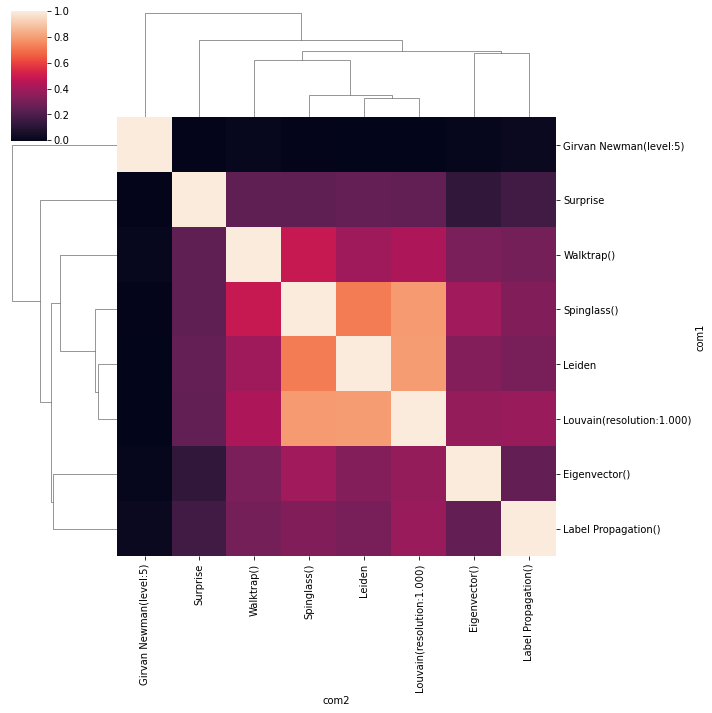

In [66]:
# OMEGA PLOT

violinplot = viz.plot_sim_matrix(community, evaluation.omega)

In [67]:
# adjusted_rand_index


arilist = []

# Генерируем последовательность для сравнения ARI of method detection Community
for i in community:
    for k in community:
        ari = evaluation.adjusted_rand_index(i,k)
        arilist.append(ari[0])

ari_com_walktrap = arilist[0: (len(community_list))]
ari_com_label = arilist[len(community_list) : 2*len(community_list)]
ari_com_eigen = arilist[2*len(community_list) : 3*len(community_list)]
ari_com_com_edge = arilist[3*len(community_list) : 4*len(community_list)]
ari_com_louvain = arilist[4*len(community_list) : 5*len(community_list)]
ari_com_spinglass = arilist[5*len(community_list) : 6*len(community_list)]
ari_com_leiden = arilist[6*len(community_list) : 7*len(community_list)]
ari_com_surprise = arilist[7*len(community_list) : 8*len(community_list)]

# Создаем датафрейм

data = {'com_walktrap' : ari_com_walktrap, 
        'com_label' : ari_com_label,
       'com_eigen': ari_com_eigen, 
       'com_edgebetweness' : ari_com_com_edge,
       'com_louvain' : ari_com_louvain,
        'com_spinglass' : ari_com_spinglass,
        'com_leiden' : ari_com_leiden,
       'com_surprise' : ari_com_surprise}

index = community_list
         
df_ari = pd.DataFrame(data, index=index)
df_ari       

,com_walktrap,com_label,com_eigen,com_edgebetweness,com_louvain,com_spinglass,com_leiden,com_surprise
com_walktrap,1.000000,0.298362,0.306838,0.016462,0.425943,0.488375,0.394842,0.247688
com_label,0.298362,1.000000,0.255315,0.025805,0.383417,0.324155,0.304561,0.171510
com_eigen,0.306838,0.255315,1.000000,0.010462,0.371228,0.398835,0.332470,0.128149
com_edge,0.016462,0.025805,0.010462,1.000000,-0.001710,0.002193,-0.002862,0.003509
com_louvain,0.425943,0.383417,0.371228,-0.001710,1.000000,0.796206,0.798476,0.250442
com_spinglass,0.488375,0.324155,0.398835,0.002193,0.796206,1.000000,0.724465,0.244215
com_leiden,0.394842,0.304561,0.332470,-0.002862,0.798476,0.724465,1.000000,0.258605
com_surprise,0.247688,0.171510,0.128149,0.003509,0.250442,0.244215,0.258605,1.000000


In [68]:
df_ari.to_csv('ari.csv', encoding ='CP1251', index=True)

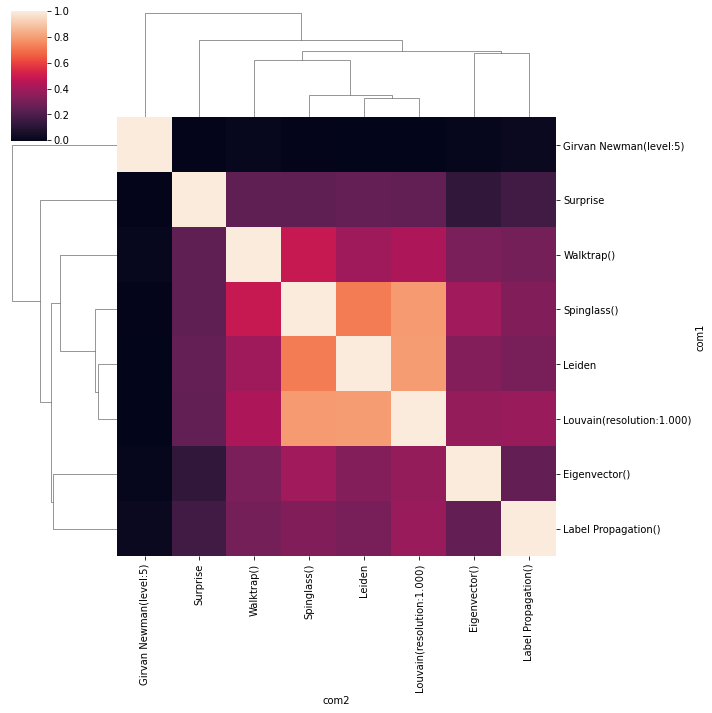

In [69]:
viz.plot_sim_matrix(community, evaluation.adjusted_rand_index)

In [73]:
###normalized_mutual_information
nmilist = []

# Генерируем последовательность для сравнения nmi of method detection Community
for i in community:
    for k in community:
        nmi = evaluation.normalized_mutual_information(i,k)
        nmilist.append(nmi[0])

nmi_com_walktrap = nmilist[0: (len(community_list))]
nmi_com_label = nmilist[len(community_list) : 2*len(community_list)]
nmi_com_eigen = nmilist[2*len(community_list) : 3*len(community_list)]
nmi_com_com_edge = nmilist[3*len(community_list) : 4*len(community_list)]
nmi_com_louvain = nmilist[4*len(community_list) : 5*len(community_list)]
nmi_com_spinglass = nmilist[5*len(community_list) : 6*len(community_list)]
nmi_com_leiden = nmilist[6*len(community_list) : 7*len(community_list)]
nmi_com_surprise = nmilist[7*len(community_list) : 8*len(community_list)]

# Создаем датафрейм

data = {'com_walktrap' : nmi_com_walktrap, 
        'com_label' : nmi_com_label,
       'com_eigen': nmi_com_eigen, 
       'com_edgebetweness' : nmi_com_com_edge,
       'com_louvain' : nmi_com_louvain,
        'com_spinglass' : nmi_com_spinglass,
        'com_leiden' : nmi_com_leiden,
       'com_surprise' : nmi_com_surprise}

index = community_list
         
df_nmi = pd.DataFrame(data, index=index)
df_nmi      


,com_walktrap,com_label,com_eigen,com_edgebetweness,com_louvain,com_spinglass,com_leiden,com_surprise
com_walktrap,1.000000,0.649638,0.491882,0.143809,0.637894,0.673528,0.616174,0.707265
com_label,0.649638,1.000000,0.473766,0.144076,0.627242,0.615819,0.598889,0.711122
com_eigen,0.491882,0.473766,1.000000,0.086391,0.478991,0.500457,0.459580,0.496021
com_edge,0.143809,0.144076,0.086391,1.000000,0.069266,0.085270,0.063331,0.102706
com_louvain,0.637894,0.627242,0.478991,0.069266,1.000000,0.842223,0.847122,0.662510
com_spinglass,0.673528,0.615819,0.500457,0.085270,0.842223,1.000000,0.802794,0.657022
com_leiden,0.616174,0.598889,0.459580,0.063331,0.847122,0.802794,1.000000,0.659087
com_surprise,0.707265,0.711122,0.496021,0.102706,0.662510,0.657022,0.659087,1.000000


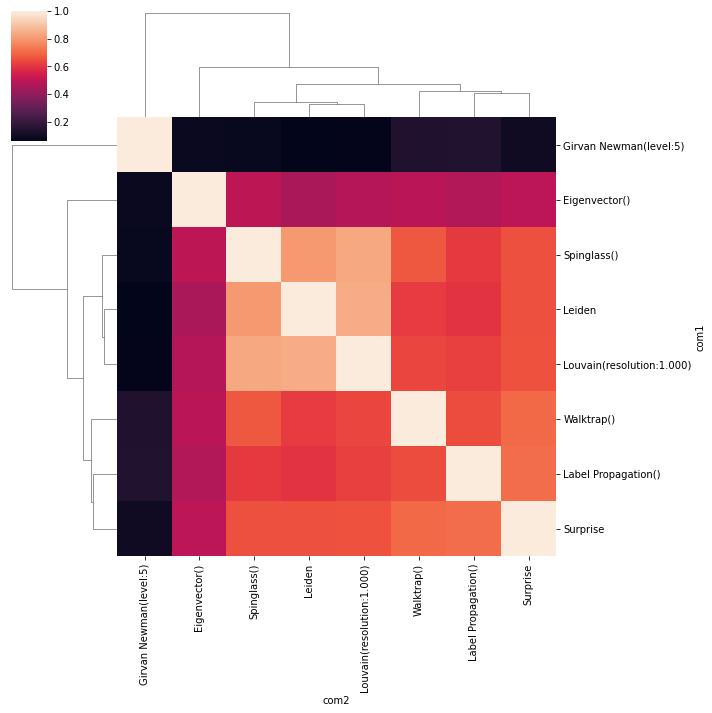

In [74]:
viz.plot_sim_matrix(community, evaluation.normalized_mutual_information)

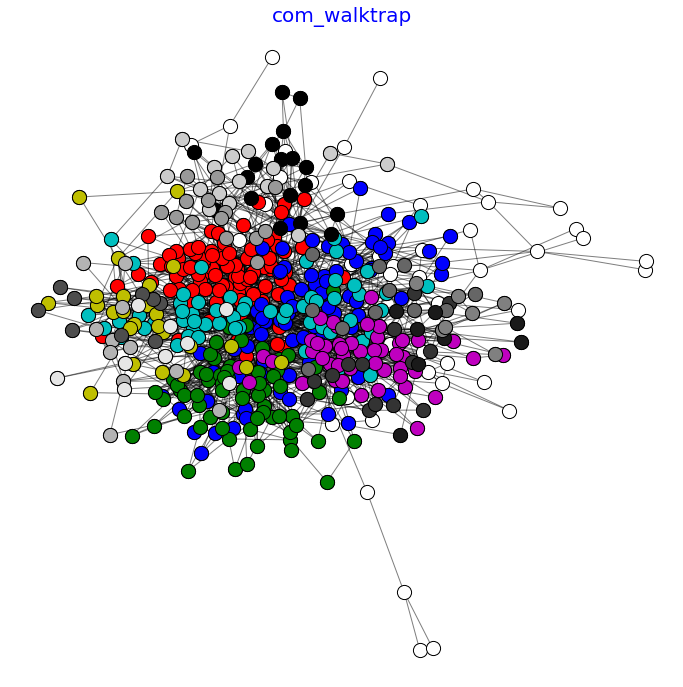

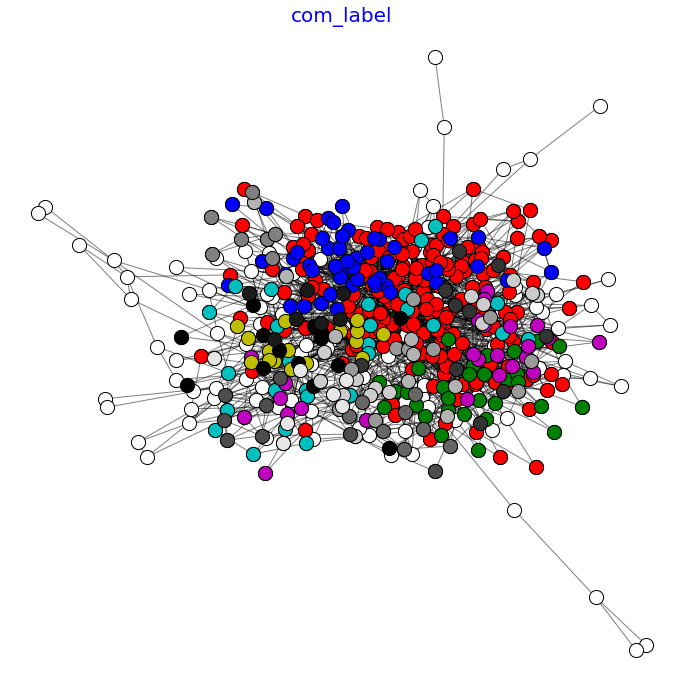

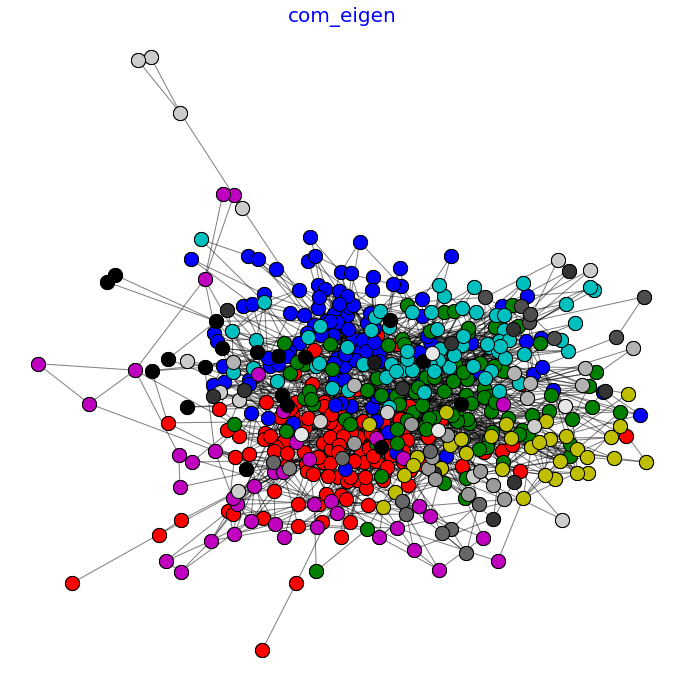

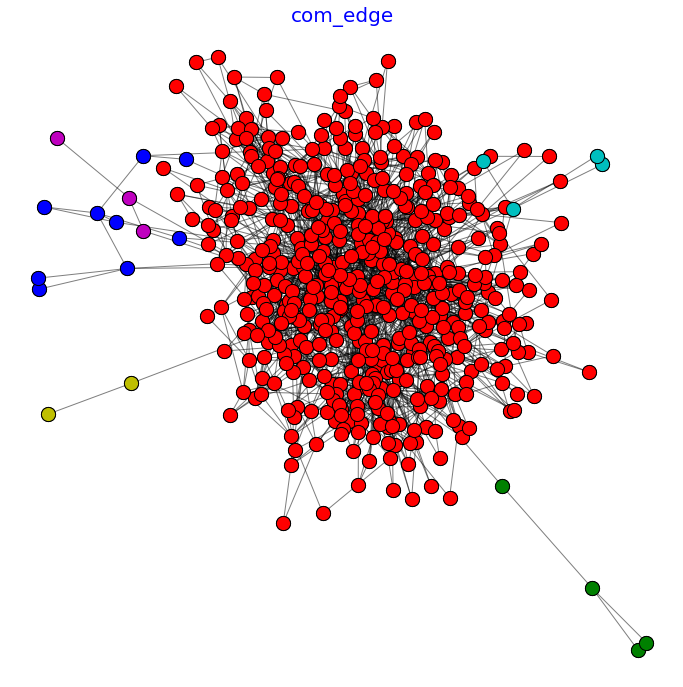

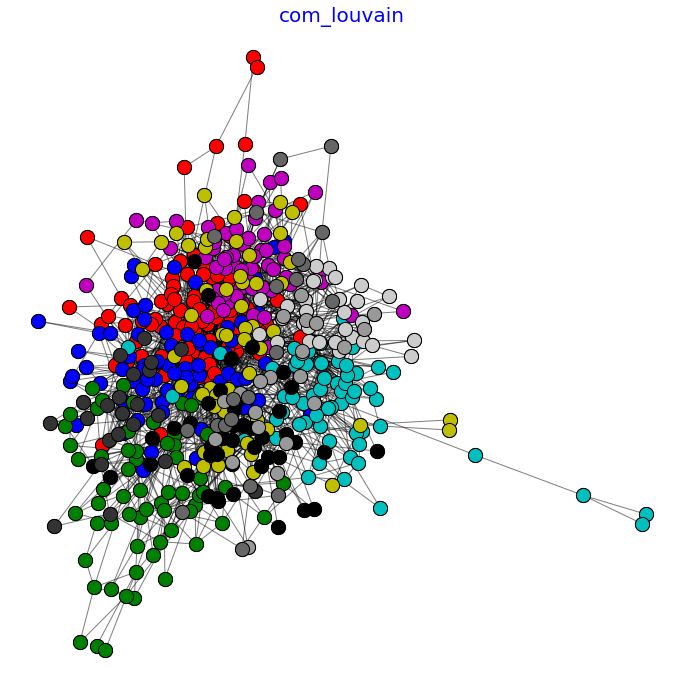

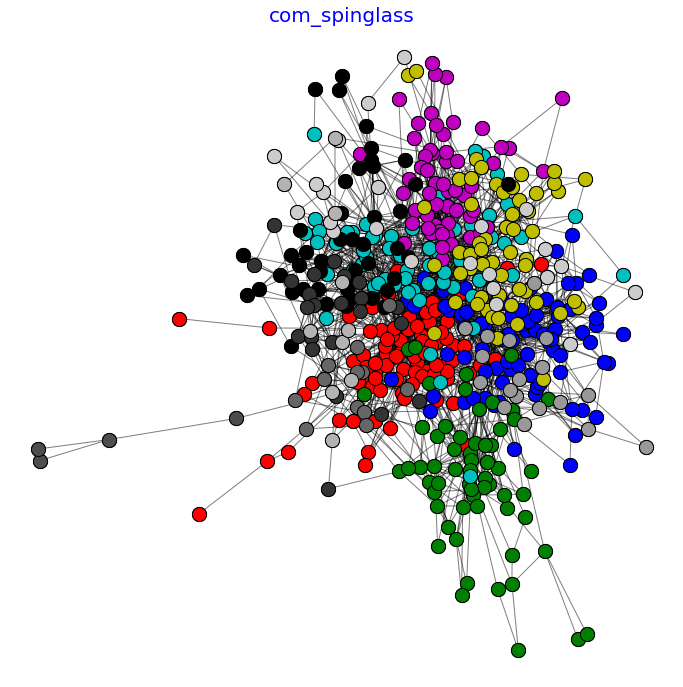

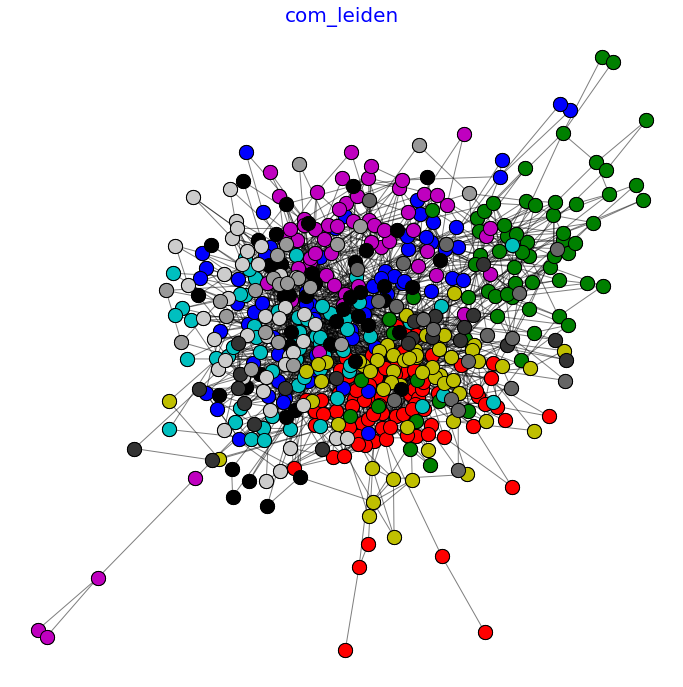

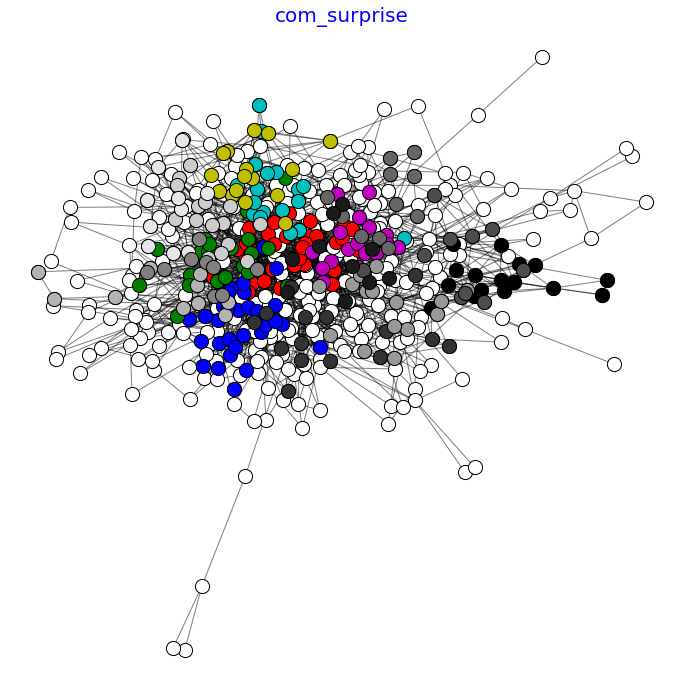

In [75]:
random.seed(41)
commun = community
com_title = community_list
for i, comm in enumerate(commun):
    #viz.plot_community_graph(g, comm)
    viz.plot_network_clusters(g, comm, figsize=(12,12))
    plt.title(com_title[i],fontsize=20, color='blue')
    


In [76]:
community_set = ['set_community_walktrap',
            'set_community_label',
            'set_community_eigen',
            'set_community_edge',
            'set_community_louvain',
            'set_community_spinglass',
            'set_community_leiden',
            'set_community_surprise']

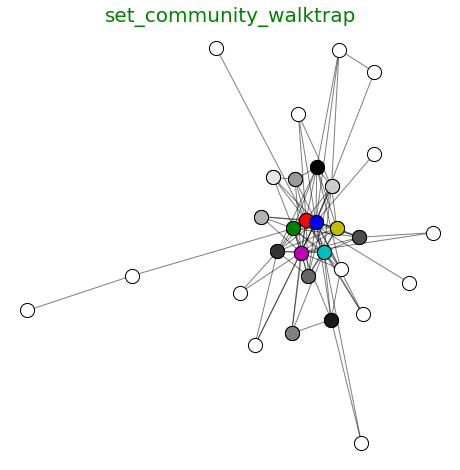

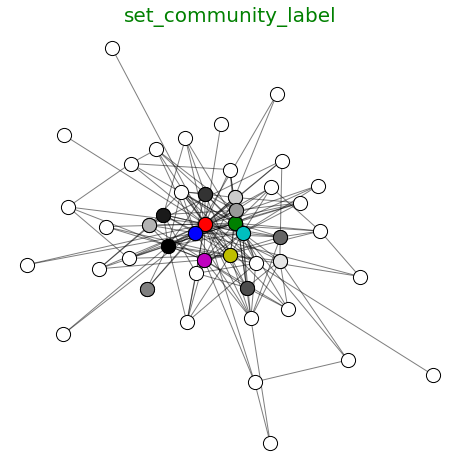

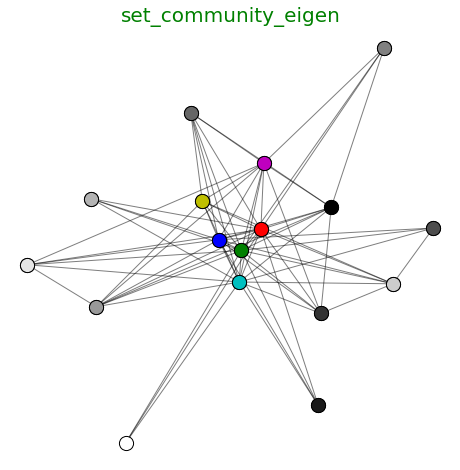

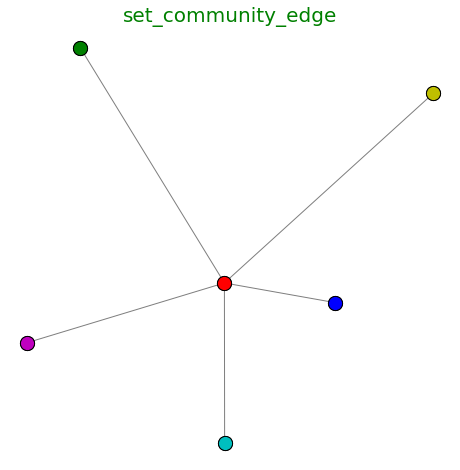

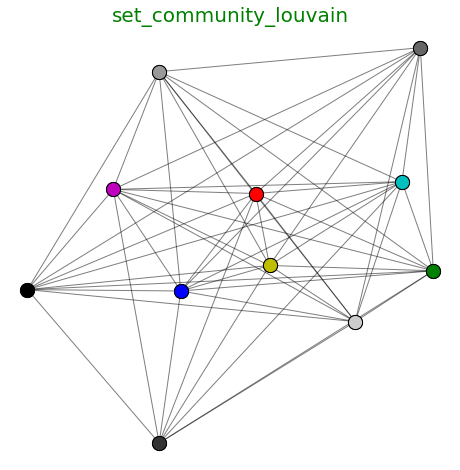

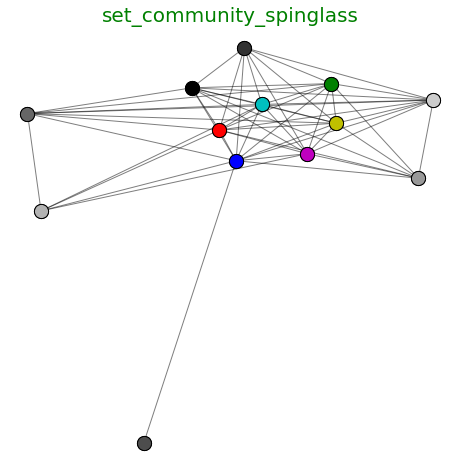

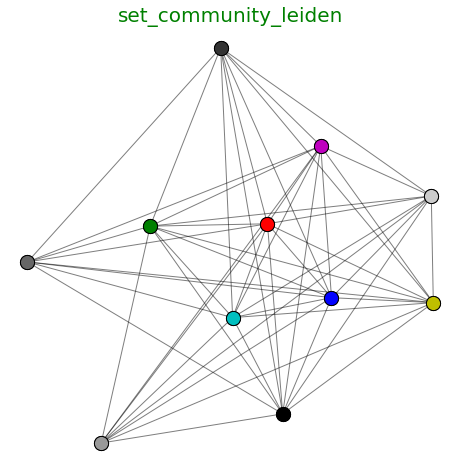

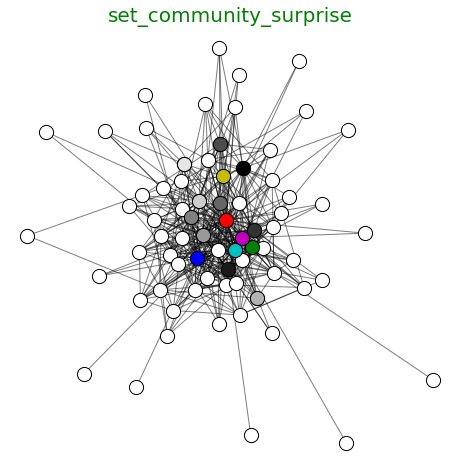

In [77]:
random.seed(41)
commun = community
com_title = community_set
for i, comm in enumerate(commun):
    viz.plot_community_graph(g, comm)
    plt.title(com_title[i],fontsize=20, color='green')

In [78]:
com_congo = algorithms.congo(g, number_communities=3, height=2)                   #+
com_demon = algorithms.demon(g, min_com_size=3, epsilon=0.25)                         #+
com_kclique = algorithms.kclique(g, k=3)

comm_overlapping = [com_congo, com_demon, com_kclique]

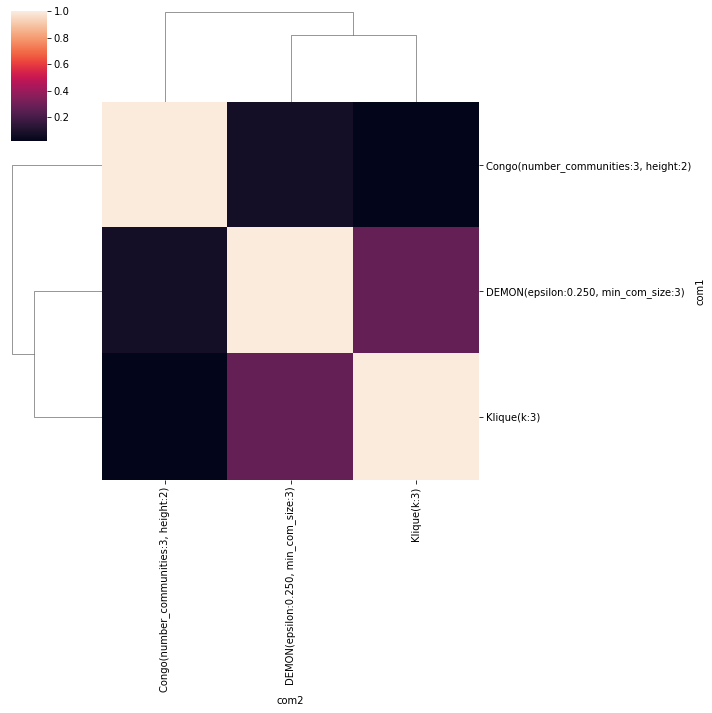

In [79]:
viz.plot_sim_matrix(comm_overlapping, evaluation.overlapping_normalized_mutual_information_LFK)

In [80]:
community_list_overlap = ['set_community_congo', 'set_community_demon', 'set_community_kclique']

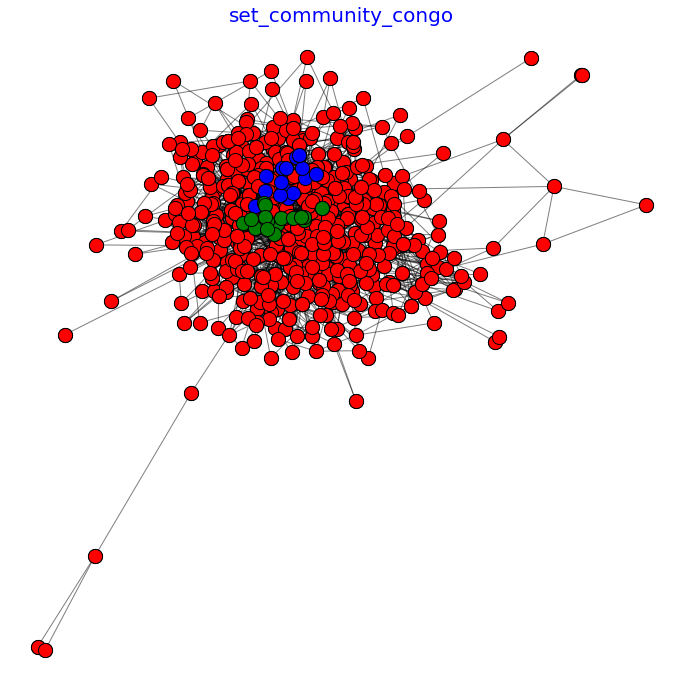

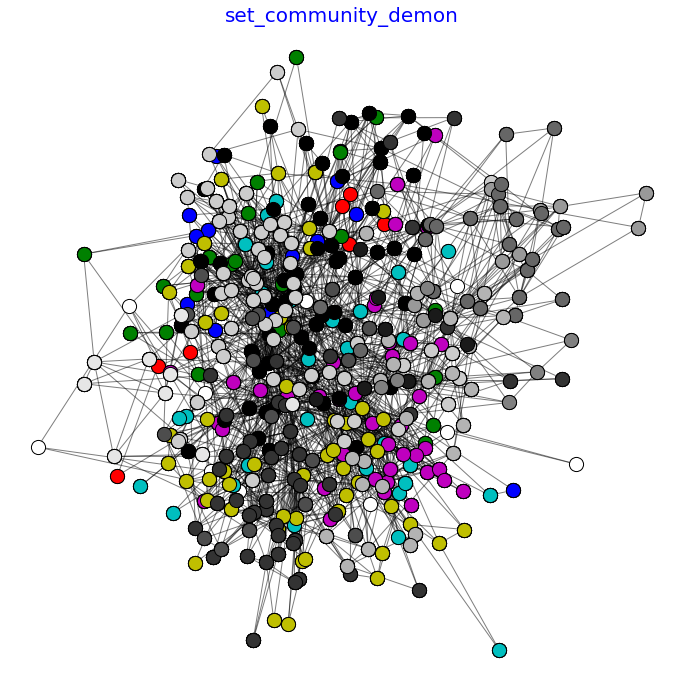

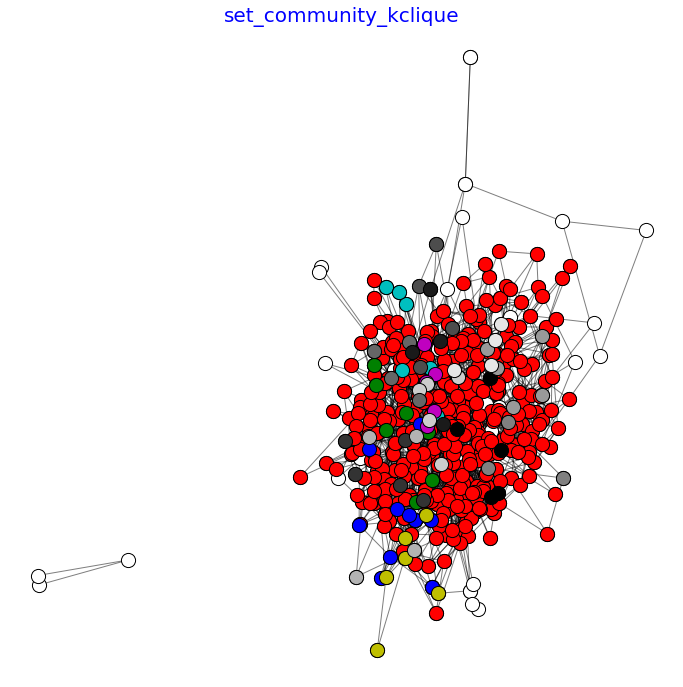

In [83]:
random.seed(41)
comm_overlapping = [com_congo, com_demon, com_kclique]
com_title = community_list_overlap
for i, comm in enumerate(comm_overlapping):
    #viz.plot_community_graph(g, comm)
    viz.plot_network_clusters(g, comm, figsize=(12,12))
    plt.title(com_title[i],fontsize=20, color='blue')

In [31]:
%time algorithms.label_propagation(g)

Wall time: 90.8 ms


In [33]:
%time algorithms.spinglass(g)

Wall time: 8.63 s


In [34]:
%time algorithms.leiden(g)

Wall time: 60.8 ms


In [35]:
%time algorithms.eigenvector(g)

Wall time: 173 ms


In [14]:
%time algorithms.surprise_communities(g)

Wall time: 27.9 ms


In [36]:
time algorithms.walktrap(g)

Wall time: 63.8 ms


In [40]:
%time algorithms.greedy_modularity(g)

Wall time: 655 ms


In [52]:
#%time algorithms.walktrap(g)
%time algorithms.louvain(g)

Wall time: 252 ms


In [53]:
%time algorithms.eigenvector(g)

Wall time: 153 ms


In [19]:
%time algorithms.leiden(g)

Wall time: 27.9 ms


In [20]:
%time algorithms.spinglass(g)

Wall time: 8.58 s


In [21]:
%time algorithms.girvan_newman(g, level=5)

Wall time: 8min 16s


In [41]:
(8*60+16)*1000

496000

In [54]:
time_algo = [63.8, 90.8, 173, 496000, 220, 8580, 60.8, 27.9] 

In [50]:
community_list1 = ['com_walktrap',
            'com_label',
            'com_eigen',
            'com_edge',
            'com_louvain',
            'com_spinglass',
            'com_leiden',
            'com_surprise']

In [57]:
import pandas as pd
community_list1 = ['com_walktrap',
            'com_label',
            'com_eigen',
            'com_edge',
            'com_louvain',
            'com_spinglass',
            'com_leiden',
            'com_surprise']

time_algo = [63.8, 90.8, 173, 496000, 220, 8580, 60.8, 27.9] 
data_time = {'time_algo, ms': time_algo}

data_time = pd.DataFrame(data_time, index=community_list1)

In [58]:
data_time

,"time_algo, ms"
com_walktrap,63.8
com_label,90.8
com_eigen,173.0
com_edge,496000.0
com_louvain,220.0
com_spinglass,8580.0
com_leiden,60.8
com_surprise,27.9
